In [1]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from catboost import CatBoostClassifier
from nltk.stem import WordNetLemmatizer
import re
from nltk.corpus import stopwords
import nltk
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

warnings.filterwarnings("ignore")

data = pd.read_csv("data/Twitter_Data.csv")

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dv\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Preparing data

shape with NaN values: (162980, 2)
(162969, 2)
shape without NaN values: (162969, 2)


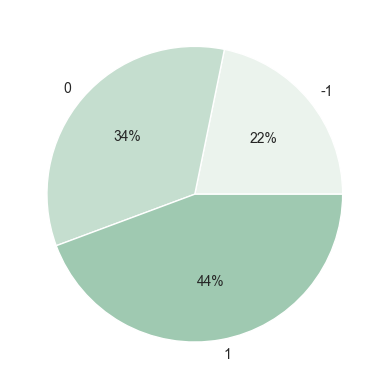

In [2]:
print(f"shape with NaN values: {data.shape}")
data = data.dropna()
print(data.shape)

print(f"shape without NaN values: {data.shape}")

data.head()

reviews = ["-1", "0", "1"]
number_of_reviews = [data['category'].value_counts()[x] for x in range(-1, 2)]

#define Seaborn color palette to use
colors = sns.light_palette('seagreen')[0:3]

#create pie chart
plt.pie(number_of_reviews, labels=reviews, colors=colors, autopct='%.0f%%')
plt.show()

In [3]:
def delete_punctuation_from_string(s: str):
    return re.sub(r'[^\w\s]', '', s)


data.loc[:, "clean_text"] = data["clean_text"].astype(str)
data.loc[:, "clean_text"] = data["clean_text"].apply(delete_punctuation_from_string)

train, test = train_test_split(data, random_state=239)

In [4]:
bow = CountVectorizer()

x_train = bow.fit_transform(train["clean_text"])
x_test = bow.transform(test["clean_text"])
y_train = train["category"]
y_test = test["category"]

import time

t = time.time()
cbc = CatBoostClassifier(task_type='GPU', learning_rate=0.3, iterations=500)
cbc.fit(x_train, y_train, verbose=False)
print(time.time() - t)

# 116.26442384719849
# 0.9301598458959877

# 113.65503215789795 0.3 / 1000
# 0.9374714628447963

# 152.65503215789795 0.3 / 1500
# 0.9374714628447963

# 155.61173748970032
# 0.9399550699946421

# 95.837233543396
# 0.8826353364534069

y_pred = cbc.predict(x_test)

print(balanced_accuracy_score(y_pred, y_test))

KeyboardInterrupt: 

### Preprocessing data better

It appeared that in case either lemmatization or deleting stopwords is applied, the accuracy is noticeably higher than with both approaches applied. Will be used just lemmatization (or maybe ensembling with stacking)

In [28]:
l = WordNetLemmatizer()

def lemmatize(x):
    x = map(lambda r: ' '.join([l.lemmatize(i.lower()) for i in r.split()]), x)
    x = np.array(list(x))
    return x


stop_words = stopwords.words('english')


def delete_stop_word(s):
    words = s.split()
    return " ".join([word for word in words if word.lower() not in stop_words])

# apply lemmatization
x_train_lemmatized = lemmatize(train["clean_text"])
x_test_lemmatized = lemmatize(test["clean_text"])

# delete stop words
train_no_sw = train["clean_text"].apply(delete_stop_word)
test_no_sw = test["clean_text"].apply(delete_stop_word)

bow = CountVectorizer()

x_train = bow.fit_transform(x_train_lemmatized)
x_test = bow.transform(x_test_lemmatized)
y_train = train["category"]
y_test = test["category"]

GridSearch suggests that iterations=1500, depth=9 and learning_rate=0.3 are optimal hyperparameters with test score accuracy: 0.8937240753012787. But even with iterations=9 and learning_rate=0.3 - all is ok (accuracy: 0.92)

In [9]:
cb_model = CatBoostClassifier(verbose=False)

cb_param_grid = {
    'iterations': [500, 1000, 1500],
    'depth': [3, 5, 7, 9],
    'learning_rate': [0.1, 0.15, 0.2, 0.3],
}

cb_gs = GridSearchCV(estimator=cb_model, param_grid=cb_param_grid, cv=3, n_jobs=-1, verbose=3)

cb_gs.fit(x_train, y_train)

print("Best parameters:", cb_gs.best_params_)
print("Best score:", cb_gs.best_score_)

best_model = cb_gs.best_estimator_
test_score = best_model.score(x_test, y_test)
print("Test set score:", test_score)

Fitting 3 folds for each of 48 candidates, totalling 144 fits
Best parameters: {'depth': 9, 'iterations': 1500, 'learning_rate': 0.3}
Best score: 0.886570778721385
Test set score: 0.8937240753012787


In [14]:
clf = CatBoostClassifier(iterations=1500, learning_rate=0.3, task_type='GPU', verbose=True)
clf.fit(x_train, y_train)

# lemmatized + without stopwords -> 0.89
# lemmatized -> 0.926
# without stopwords -> 0.9023

y_pred = clf.predict(x_test)

print("CatBoost", balanced_accuracy_score(y_pred, y_test))

0:	learn: 1.0415294	total: 624ms	remaining: 15m 35s
1:	learn: 1.0051621	total: 709ms	remaining: 8m 51s
2:	learn: 0.9800016	total: 791ms	remaining: 6m 34s
3:	learn: 0.9611068	total: 863ms	remaining: 5m 22s
4:	learn: 0.9452029	total: 937ms	remaining: 4m 40s
5:	learn: 0.9317957	total: 1.01s	remaining: 4m 11s
6:	learn: 0.9201554	total: 1.07s	remaining: 3m 49s
7:	learn: 0.9089456	total: 1.14s	remaining: 3m 31s
8:	learn: 0.8982294	total: 1.2s	remaining: 3m 18s
9:	learn: 0.8883140	total: 1.26s	remaining: 3m 7s
10:	learn: 0.8795452	total: 1.32s	remaining: 2m 58s
11:	learn: 0.8711046	total: 1.38s	remaining: 2m 51s
12:	learn: 0.8630140	total: 1.44s	remaining: 2m 44s
13:	learn: 0.8546891	total: 1.51s	remaining: 2m 40s
14:	learn: 0.8471710	total: 1.59s	remaining: 2m 37s
15:	learn: 0.8401362	total: 1.65s	remaining: 2m 33s
16:	learn: 0.8325843	total: 1.73s	remaining: 2m 30s
17:	learn: 0.8261802	total: 1.79s	remaining: 2m 27s
18:	learn: 0.8199579	total: 1.86s	remaining: 2m 25s
19:	learn: 0.8140801	to

In [24]:
logr = LogisticRegression(verbose=True)
logr.fit(x_train, y_train)

# lemmatized + without stopwords -> 0.884258
# lemmatized -> 0.925
# without stopwords -> 0.89744

y_pred = logr.predict(x_test)

print("Logistic", balanced_accuracy_score(y_pred, y_test))

Logistic 0.8842581818979977


In [29]:
rf = RandomForestClassifier(verbose=True, n_jobs=-1)
rf.fit(x_train, y_train)

# lemmatized + without stopwords -> 0.84985
# lemmatized -> 0.8482033
# without stopwords -> 0.8480635

y_pred = rf.predict(x_test)

print("Random forest", balanced_accuracy_score(y_pred, y_test))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   44.6s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s


Random forest 0.848203308202827


[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.1s finished


Tried LogisticRegression and RandomForestClassifier with no hyperparameter tuning and both display a reasonable accuracy: LR - 0.89744, RF - 0.86577


In [12]:
def training_pipeline(model):
    cv = CountVectorizer()

    x_train_lemmatized = cv.fit_transform(lemmatize(train["clean_text"]))
    x_test_lemmatized = cv.fit(test["clean_text"])
        
    model.fit(x_train_lemmatized, y_train)
    y_pred_lemmed = model.predict(x_test_lemmatized)
    print('lemmatized:', balanced_accuracy_score(y_test, y_pred_lemmed))
    
    # x_train_no_sw = delete_stop_word(train["clean_text"])
    # x_test_no_sw = delete_stop_word(test["clean_text"])
    # 
    # model.fit(x_train_no_sw, y_train)
    # y_pred_no_sw = model.predict(x_test_lemmatized)
    # print('No sw:', balanced_accuracy_score(y_test, y_pred_no_sw))
    # 
    # x_train_lemmatized_no_sw = lemmatize(x_train_no_sw)
    # x_test_lemmatized_no_sw = lemmatize(x_test_no_sw)
    # 
    # 
    # 
    # model.fit(x_train_no_sw, y_train)
    # model.fit(x_train_lemmatized, y_train)
    # y_pred_no_sw = model.predict(x_test_lemmatized)
    # print('lemmatized:', balanced_accuracy_score(y_test, y_pred_lemmed))
    # 
    # model.fit(x_train_lemmatized_no_sw, y_train)

In [13]:
training_pipeline(LogisticRegression())

ValueError: Expected 2D array, got scalar array instead:
array=CountVectorizer().
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.